In [14]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 1.2 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [55]:
import boto3
import pandas as pd; pd.set_option('display.max_column', 100)
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,  GradientBoostingClassifier 
from sklearn.tree import DecisionTreeClassifier


import matplotlib.pyplot as plt
from itertools import product
import xgboost as xgb 





s3= boto3.resource('s3')
bucket_name= 'morgangant-bata-445-bucket'
bucket= s3.Bucket(bucket_name)

file_key= 'train.csv'

bucket_object= bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

#reading the datefile
project = pd.read_csv(file_content_stream)
project.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemsVoids,scansWithoutRegistration,quanitityModification,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemsVoids,scansWithoutRegistration,quanitityModification,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [56]:
#Dropping na values
project = project.dropna()

In [7]:
importances= list()
for i in range (1,100):
    ## Defining the input and taregt variables
    x= project[['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemsVoids', 'scansWithoutRegistration', 'quanitityModification', 'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition']]
    y= project['fraud']

    #Splitting data into train and test
    x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2)

    #Building Model
    RF_md= RandomForestClassifier(n_estimators= 500).fit(x_train, y_train)

    #Extracting the feature importances
    importances.append(RF_md.feature_importances_)

In [8]:
a = pd.DataFrame(importances)
a.columns= ['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemsVoids', 'scansWithoutRegistration', 'quanitityModification', 'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition']
a.apply(np.mean, axis = 0)

trustLevel                   0.267337
totalScanTimeInSeconds       0.146603
grandTotal                   0.069167
lineItemsVoids               0.070835
scansWithoutRegistration     0.054783
quanitityModification        0.024785
scannedLineItemsPerSecond    0.166051
valuePerSecond               0.091405
lineItemVoidsPerPosition     0.109034
dtype: float64

In [57]:
def expand_grid(dictionary1):
    return pd.DataFrame([row for row in product(*dictionary1.values())], 
                        columns = dictionary1.keys())
dictionary1 = {'n_tree': [100, 300, 500, 1000], 
                'depth': [3, 5, 7]}
parameters1= expand_grid(dictionary1)
parameters1= expand_grid(dictionary1)

In [10]:
parameters1

,n_tree,depth,recall
0,100,3,NaN
1,100,5,NaN
2,100,7,NaN
3,300,3,NaN
4,300,5,NaN
5,300,7,NaN
6,500,3,NaN
7,500,5,NaN
8,500,7,NaN
9,1000,3,NaN


In [58]:
def expand_grid(dictionary2):
    return pd.DataFrame([row for row in product(*dictionary2.values())], 
                        columns = dictionary2.keys())
dictionary2 = {'n_tree': [100, 300, 500, 1000], 
                'depth': [3, 5, 7], 
                'learning_rate': [0.1, 0.01, 0.001]}
parameters2 = expand_grid(dictionary2)

In [11]:
parameters2

,n_tree,depth,learning_rate,recall
0,100,3,0.100,NaN
1,100,3,0.010,NaN
2,100,3,0.001,NaN
3,100,5,0.100,NaN
4,100,5,0.010,NaN
5,100,5,0.001,NaN
6,100,7,0.100,NaN
7,100,7,0.010,NaN
8,100,7,0.001,NaN
9,300,3,0.100,NaN


In [59]:
def expand_grid(dictionary3):
    return pd.DataFrame([row for row in product(*dictionary3.values())],
                        columns = dictionary3.keys())
dictionary3 = {'n_tree': [100, 300, 500, 1000],
                'depth': [3, 5, 7], 
                'learning_rate': [0.1, 0.01, 0.001]}
parameters3 = expand_grid(dictionary3)

In [47]:
parameters3

,n_tree,depth,learning_rate
0,100,3,0.100
1,100,3,0.010
2,100,3,0.001
3,100,5,0.100
4,100,5,0.010
5,100,5,0.001
6,100,7,0.100
7,100,7,0.010
8,100,7,0.001
9,500,3,0.100


,n_tree,depth,learning_rate
0,100,3,0.100
1,100,3,0.010
2,100,3,0.001
3,100,5,0.100
4,100,5,0.010
5,100,5,0.001
6,100,7,0.100
7,100,7,0.010
8,100,7,0.001
9,500,3,0.100


In [61]:
#defining data frames to hold data
rf_recall= pd.DataFrame()
xgb_recall= pd.DataFrame()
ada_recall= pd.DataFrame()

#Define the input and target variable
x= project[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
y= project['fraud']


for i in range (0,100):
    
    print([i])

    
    #Splitting the Data
    x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, stratify= y)
    
    ##### Random Forest
    for k in range(len(parameters1)):
        print([k])
        #Buidling the model
        rf_md1= RandomForestClassifier(n_estimators= parameters1['n_tree'][k], max_depth=parameters1['depth'][k]).fit(x_train, y_train)
        #Predicting on the model
        rf_pred1= rf_md1.predict_proba(x_test)[:,1]
        #changing likelihoods to labels 
        rf_labels1= np.where(rf_pred1 < .1, 0, 1)
        rf_recall.loc[i,k]= recall_score(y_test, rf_labels1)
    
    
    #### XGBoost
    for m in range(len(parameters2)):
        print([m])
        #creating model
        xgb_md= xgb.XGBClassifier(max_depth= parameters2['depth'][m], n_estimators= parameters2['n_tree'][m], learning_rate= parameters2['learning_rate'][m] ).fit(x_train, y_train)
        #predicitng on the model
        xgb_pred= xgb_md.predict_proba(x_test)[:,1]
        #Changling likleyhoods to labels
        xgb_labels1= np.where(xgb_pred < .1, 0, 1)
        #Computing recall and appending score
        xgb_recall.loc[i,m]= recall_score(y_test, xgb_labels1)
  
    #### Ada Boost    
    for g in range(len(parameters3)):
        print([g])
        #Building the model
        ada_md1= AdaBoostClassifier(base_estimator= DecisionTreeClassifier(max_depth= parameters2['n_tree'][m]), n_estimators= parameters2['depth'][m], learning_rate= parameters2['learning_rate'][m]).fit(x_train, y_train)
        #Predicting on the model
        ada_pred1= ada_md1.predict_proba(x_test)[:,1]
        #changing likelihoods to labels 
        ada_labels1= np.where(ada_pred1 < .1, 0, 1)
        ada_recall.loc[i,g]= recall_score(y_test, ada_labels1)

[0]
[0]
[0]
[0]
[1]
[2]
[1]
[2]
[3]
[3]
[4]
[4]
[5]
[5]
[6]
[6]
[7]
[7]
[8]
[8]
[9]
[9]
[10]
[10]
[11]
[11]
[0]
[1]
[2]
[0]
[1]
[2]
[3]
[4]
[3]
[4]
[5]
[6]
[5]
[6]
[7]
[8]
[7]
[8]
[9]
[9]
[10]
[10]
[11]
[11]
[12]
[12]
[13]
[13]
[14]
[14]
[15]
[15]
[16]
[16]
[17]
[17]
[18]
[18]
[19]
[19]
[20]
[20]
[21]
[21]
[22]
[22]
[23]
[23]
[24]
[24]
[25]
[25]
[26]
[26]
[27]
[27]
[28]
[28]
[29]
[29]
[30]
[30]
[31]
[31]
[32]
[32]
[33]
[33]
[34]
[34]
[35]
[35]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[1]
[0]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[1]
[0]
[1]
[2]
[1]
[2]
[3]
[3]
[4]
[4]
[5]
[5]
[6]
[6]
[7]
[7]
[8]
[8]
[9]
[9]
[10]
[10]
[11]
[11]
[0]
[1]
[2]
[0]
[1]
[2]
[3]
[4]
[3]
[4]
[5]
[6]
[5]
[6]
[7]
[8]
[7]
[8]
[9]
[9]
[10]
[10]
[11]
[11]
[12]

In [63]:
rf_recall.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.879048,0.939524,0.945714,0.880476,0.940476,0.948571,0.880000,0.938571,0.948095,0.880000,0.943810,0.946190
std,0.079630,0.054925,0.047869,0.081077,0.054725,0.044217,0.080506,0.055523,0.047904,0.083302,0.050821,0.048645
min,0.619048,0.761905,0.809524,0.619048,0.761905,0.857143,0.666667,0.809524,0.809524,0.619048,0.809524,0.809524
25%,0.809524,0.904762,0.904762,0.809524,0.904762,0.904762,0.809524,0.904762,0.904762,0.809524,0.904762,0.904762
50%,0.904762,0.952381,0.952381,0.904762,0.952381,0.952381,0.904762,0.952381,0.952381,0.904762,0.952381,0.952381
75%,0.952381,1.000000,1.000000,0.952381,1.000000,1.000000,0.952381,1.000000,1.000000,0.952381,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,0,1,2,3,4,5,6,7,8,9,10,11
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.879048,0.939524,0.945714,0.880476,0.940476,0.948571,0.880000,0.938571,0.948095,0.880000,0.943810,0.946190
std,0.079630,0.054925,0.047869,0.081077,0.054725,0.044217,0.080506,0.055523,0.047904,0.083302,0.050821,0.048645
min,0.619048,0.761905,0.809524,0.619048,0.761905,0.857143,0.666667,0.809524,0.809524,0.619048,0.809524,0.809524
25%,0.809524,0.904762,0.904762,0.809524,0.904762,0.904762,0.809524,0.904762,0.904762,0.809524,0.904762,0.904762
50%,0.904762,0.952381,0.952381,0.904762,0.952381,0.952381,0.904762,0.952381,0.952381,0.904762,0.952381,0.952381
75%,0.952381,1.000000,1.000000,0.952381,1.000000,1.000000,0.952381,1.000000,1.000000,0.952381,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
xgb_recall.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
count,100.000000,100.0,100.0,100.000000,100.0,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0
mean,0.946190,1.0,1.0,0.909048,1.0,1.0,0.897619,1.0,1.0,0.900952,0.972381,1.0,0.876667,0.950476,1.0,0.872381,0.939048,1.0,0.871905,0.963333,1.0,0.861905,0.930000,1.0,0.863810,0.925238,1.0,0.850952,0.948095,1.0,0.856667,0.909524,1.0,0.860952,0.899524,1.0
std,0.051836,0.0,0.0,0.067035,0.0,0.0,0.065752,0.0,0.0,0.070559,0.035286,0.0,0.077198,0.048769,0.0,0.072227,0.055845,0.0,0.078842,0.045832,0.0,0.081360,0.058402,0.0,0.078061,0.057929,0.0,0.080839,0.051588,0.0,0.079364,0.067852,0.0,0.077962,0.066624,0.0
min,0.761905,1.0,1.0,0.714286,1.0,1.0,0.714286,1.0,1.0,0.666667,0.857143,1.0,0.666667,0.761905,1.0,0.666667,0.761905,1.0,0.666667,0.761905,1.0,0.619048,0.761905,1.0,0.619048,0.761905,1.0,0.619048,0.761905,1.0,0.619048,0.714286,1.0,0.619048,0.714286,1.0
25%,0.904762,1.0,1.0,0.892857,1.0,1.0,0.857143,1.0,1.0,0.857143,0.952381,1.0,0.845238,0.904762,1.0,0.809524,0.904762,1.0,0.809524,0.952381,1.0,0.809524,0.904762,1.0,0.809524,0.904762,1.0,0.809524,0.904762,1.0,0.809524,0.857143,1.0,0.809524,0.857143,1.0
50%,0.952381,1.0,1.0,0.904762,1.0,1.0,0.904762,1.0,1.0,0.904762,1.000000,1.0,0.904762,0.952381,1.0,0.880952,0.952381,1.0,0.904762,0.976190,1.0,0.857143,0.952381,1.0,0.857143,0.904762,1.0,0.857143,0.952381,1.0,0.857143,0.904762,1.0,0.857143,0.904762,1.0
75%,1.000000,1.0,1.0,0.952381,1.0,1.0,0.952381,1.0,1.0,0.952381,1.000000,1.0,0.904762,1.000000,1.0,0.904762,1.000000,1.0,0.904762,1.000000,1.0,0.904762,1.000000,1.0,0.904762,0.952381,1.0,0.904762,1.000000,1.0,0.904762,0.952381,1.0,0.904762,0.952381,1.0
max,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
count,100.000000,100.0,100.0,100.000000,100.0,100.0,100.000000,100.0,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0,100.000000,100.000000,100.0
mean,0.946190,1.0,1.0,0.909048,1.0,1.0,0.897619,1.0,1.0,0.900952,0.972381,1.0,0.876667,0.950476,1.0,0.872381,0.939048,1.0,0.871905,0.963333,1.0,0.861905,0.930000,1.0,0.863810,0.925238,1.0,0.850952,0.948095,1.0,0.856667,0.909524,1.0,0.860952,0.899524,1.0
std,0.051836,0.0,0.0,0.067035,0.0,0.0,0.065752,0.0,0.0,0.070559,0.035286,0.0,0.077198,0.048769,0.0,0.072227,0.055845,0.0,0.078842,0.045832,0.0,0.081360,0.058402,0.0,0.078061,0.057929,0.0,0.080839,0.051588,0.0,0.079364,0.067852,0.0,0.077962,0.066624,0.0
min,0.761905,1.0,1.0,0.714286,1.0,1.0,0.714286,1.0,1.0,0.666667,0.857143,1.0,0.666667,0.761905,1.0,0.666667,0.761905,1.0,0.666667,0.761905,1.0,0.619048,0.761905,1.0,0.619048,0.761905,1.0,0.619048,0.761905,1.0,0.619048,0.714286,1.0,0.619048,0.714286,1.0
25%,0.904762,1.0,1.0,0.892857,1.0,1.0,0.857143,1.0,1.0,0.857143,0.952381,1.0,0.845238,0.904762,1.0,0.809524,0.904762,1.0,0.809524,0.952381,1.0,0.809524,0.904762,1.0,0.809524,0.904762,1.0,0.809524,0.904762,1.0,0.809524,0.857143,1.0,0.809524,0.857143,1.0
50%,0.952381,1.0,1.0,0.904762,1.0,1.0,0.904762,1.0,1.0,0.904762,1.000000,1.0,0.904762,0.952381,1.0,0.880952,0.952381,1.0,0.904762,0.976190,1.0,0.857143,0.952381,1.0,0.857143,0.904762,1.0,0.857143,0.952381,1.0,0.857143,0.904762,1.0,0.857143,0.904762,1.0
75%,1.000000,1.0,1.0,0.952381,1.0,1.0,0.952381,1.0,1.0,0.952381,1.000000,1.0,0.904762,1.000000,1.0,0.904762,1.000000,1.0,0.904762,1.000000,1.0,0.904762,1.000000,1.0,0.904762,0.952381,1.0,0.904762,1.000000,1.0,0.904762,0.952381,1.0,0.904762,0.952381,1.0
max,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0


In [65]:
ada_recall.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.661905,0.663333,0.661905,0.659048,0.659524,0.655714,0.660952,0.657619,0.659524,0.660952,0.655714,0.658095,0.663333,0.660000,0.658571,0.662857,0.656667,0.660000,0.661429,0.658095,0.658095,0.659524,0.657619,0.658571,0.657619,0.661429,0.658095,0.660952,0.659048,0.657143,0.658571,0.659524,0.662857,0.658571,0.659524,0.655238
std,0.102980,0.101356,0.102087,0.102583,0.102506,0.107625,0.104258,0.104129,0.105805,0.104477,0.099209,0.102508,0.107070,0.101529,0.106813,0.098240,0.108143,0.100394,0.099908,0.101610,0.104060,0.103618,0.107591,0.100174,0.103909,0.101726,0.106669,0.101813,0.105011,0.100390,0.105519,0.103175,0.104565,0.104208,0.105805,0.102896
min,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.380952,0.380952,0.428571,0.428571,0.428571,0.380952,0.428571,0.428571,0.428571,0.380952,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.380952,0.428571,0.428571,0.380952,0.380952,0.333333,0.380952,0.428571,0.428571,0.428571
25%,0.571429,0.571429,0.607143,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.619048,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.607143,0.571429,0.571429,0.619048,0.571429,0.571429,0.571429
50%,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
75%,0.726190,0.726190,0.714286,0.726190,0.761905,0.714286,0.761905,0.714286,0.714286,0.761905,0.726190,0.726190,0.761905,0.726190,0.761905,0.714286,0.714286,0.726190,0.726190,0.714286,0.714286,0.726190,0.714286,0.726190,0.761905,0.761905,0.726190,0.761905,0.714286,0.714286,0.761905,0.726190,0.761905,0.726190,0.761905,0.714286
max,0.904762,0.904762,0.904762,0.857143,0.857143,0.904762,0.904762,0.904762,0.904762,0.904762,0.857143,0.857143,0.904762,0.904762,0.857143,0.857143,0.952381,0.857143,0.904762,0.904762,0.904762,0.904762,0.904762,0.904762,0.857143,0.904762,0.952381,0.904762,0.904762,0.857143,0.857143,0.857143,0.857143,0.904762,0.952381,0.857143


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.661905,0.663333,0.661905,0.659048,0.659524,0.655714,0.660952,0.657619,0.659524,0.660952,0.655714,0.658095,0.663333,0.660000,0.658571,0.662857,0.656667,0.660000,0.661429,0.658095,0.658095,0.659524,0.657619,0.658571,0.657619,0.661429,0.658095,0.660952,0.659048,0.657143,0.658571,0.659524,0.662857,0.658571,0.659524,0.655238
std,0.102980,0.101356,0.102087,0.102583,0.102506,0.107625,0.104258,0.104129,0.105805,0.104477,0.099209,0.102508,0.107070,0.101529,0.106813,0.098240,0.108143,0.100394,0.099908,0.101610,0.104060,0.103618,0.107591,0.100174,0.103909,0.101726,0.106669,0.101813,0.105011,0.100390,0.105519,0.103175,0.104565,0.104208,0.105805,0.102896
min,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.380952,0.380952,0.428571,0.428571,0.428571,0.380952,0.428571,0.428571,0.428571,0.380952,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.380952,0.428571,0.428571,0.380952,0.380952,0.333333,0.380952,0.428571,0.428571,0.428571
25%,0.571429,0.571429,0.607143,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.619048,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.607143,0.571429,0.571429,0.619048,0.571429,0.571429,0.571429
50%,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
75%,0.726190,0.726190,0.714286,0.726190,0.761905,0.714286,0.761905,0.714286,0.714286,0.761905,0.726190,0.726190,0.761905,0.726190,0.761905,0.714286,0.714286,0.726190,0.726190,0.714286,0.714286,0.726190,0.714286,0.726190,0.761905,0.761905,0.726190,0.761905,0.714286,0.714286,0.761905,0.726190,0.761905,0.726190,0.761905,0.714286
max,0.904762,0.904762,0.904762,0.857143,0.857143,0.904762,0.904762,0.904762,0.904762,0.904762,0.857143,0.857143,0.904762,0.904762,0.857143,0.857143,0.952381,0.857143,0.904762,0.904762,0.904762,0.904762,0.904762,0.904762,0.857143,0.904762,0.952381,0.904762,0.904762,0.857143,0.857143,0.857143,0.857143,0.904762,0.952381,0.857143


In [44]:
parameters2

,n_tree,depth,learning_rate,recall
0,100,3,0.100,NaN
1,100,3,0.010,NaN
2,100,3,0.001,NaN
3,100,5,0.100,NaN
4,100,5,0.010,NaN
5,100,5,0.001,NaN
6,100,7,0.100,NaN
7,100,7,0.010,NaN
8,100,7,0.001,NaN
9,300,3,0.100,NaN


In [ ]:
#Trying different number of trees
md1_results= list()
md2_results= list()
md3_results= list()

#Define the input and target variable
x= project[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
y= project['fraud']
    
#depth of 7

for i in range (0,1000):

    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify=y)

    #Creating RF model with 100 estimators
    RF_md= RandomForestClassifier(max_depth= 7, n_estimators= 100).fit(x_train, y_train)
    #Predictingon the model
    RF_pred= RF_md.predict_proba(x_test)[:,1]
    RF_pred
    #Changling likleyhoods to labels
    RF_label= np.where(RF_pred < .1, 0, 1)
    #Computing recall
    Model1_recall= recall_score(y_test, RF_label)
    md1_results.append(Model1_recall)


    #Creating RF model with 300 estimators
    RF_md2= RandomForestClassifier(max_depth= 7, n_estimators= 300).fit(x_train, y_train)
    #Predictingon the model
    RF_pred2= RF_md2.predict_proba(x_test)[:,1]
    RF_pred2
    #Changling likleyhoods to labels
    RF_label2= np.where(RF_pred2 < .1, 0, 1)
    #Computing recall
    Model2_recall= recall_score(y_test, RF_label2)
    md2_results.append(Model2_recall)


    #Creating RF model with 500 estimators
    RF_md3= RandomForestClassifier(max_depth= 7, n_estimators= 500).fit(x_train, y_train)
    #Predictingon the model
    RF_pred3= RF_md3.predict_proba(x_test)[:,1]
    RF_pred3
    #Changling likleyhoods to labels
    RF_label3= np.where(RF_pred3 < .1, 0, 1)
    #Computing recall
    Model3_recall= recall_score(y_test, RF_label3)
    md3_results.append(Model3_recall)

In [4]:
#Computing averages
print('Average Recall for model 1:', np.mean(md1_results))
print('Average Recall for model 2:',np.mean(md2_results))
print('Average Recall for model 3:',np.mean(md3_results))

Average Recall for model 1: 0.9377619047619048
Average Recall for model 2: 0.9367142857142858
Average Recall for model 3: 0.9372857142857144


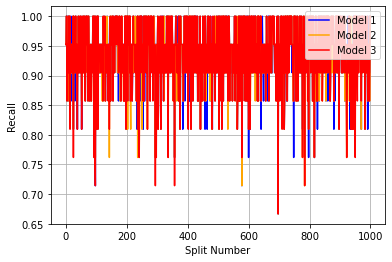

In [5]:
x= [i for i in range(0,1000)]
plt.plot(x, md1_results, color = 'blue')
plt.plot(x, md2_results, color = 'orange')
plt.plot(x, md3_results, color = 'red')
plt.xlabel('Split Number')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3'])
plt.grid()
plt.show();

In [43]:
#DONE
#Trying different number of trees
md1_results= list()
md2_results= list()
md3_results= list()

#Define the input and target variable
x= project[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
y= project['fraud']
    
#depth of 3
    
for i in range (0,1000):

    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify=y)

    #Creating RF model with 100 estimators
    RF_md= RandomForestClassifier(max_depth= 3, n_estimators= 100).fit(x_train, y_train)
    #Predictingon the model
    RF_pred= RF_md.predict_proba(x_test)[:,1]
    RF_pred
    #Changling likleyhoods to labels
    RF_label= np.where(RF_pred < .1, 0, 1)
    #Computing recall
    Model1_recall= recall_score(y_test, RF_label)
    md1_results.append(Model1_recall)


    #Creating RF model with with 300 estimators
    RF_md2= RandomForestClassifier(max_depth= 3, n_estimators= 300).fit(x_train, y_train)
    #Predictingon the model
    RF_pred2= RF_md2.predict_proba(x_test)[:,1]
    RF_pred2
    #Changling likleyhoods to labels
    RF_label2= np.where(RF_pred2 < .1, 0, 1)
    #Computing recall
    Model2_recall= recall_score(y_test, RF_label2)
    md2_results.append(Model2_recall)


    #Creating RF model with 500 estimators
    RF_md3= RandomForestClassifier(max_depth= 3, n_estimators= 500).fit(x_train, y_train)
    #Predictingon the model
    RF_pred3= RF_md3.predict_proba(x_test)[:,1]
    RF_pred3
    #Changling likleyhoods to labels
    RF_label3= np.where(RF_pred3 < .1, 0, 1)
    #Computing recall
    Model3_recall= recall_score(y_test, RF_label3)
    md3_results.append(Model3_recall)

In [44]:
#Computing averages
print('Average Recall for model 1:', np.mean(md1_results))
print('Average Recall for model 2:',np.mean(md2_results))
print('Average Recall for model 3:',np.mean(md3_results))

Average Recall for model 1: 0.8778095238095238
Average Recall for model 2: 0.8776190476190477
Average Recall for model 3: 0.8766190476190477


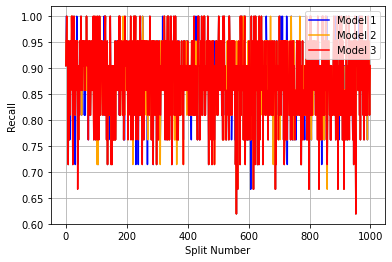

In [45]:
x= [i for i in range(0,1000)]
plt.plot(x, md1_results, color = 'blue')
plt.plot(x, md2_results, color = 'orange')
plt.plot(x, md3_results, color = 'red')
plt.xlabel('Split Number')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3'])
plt.grid()
plt.show();

In [39]:
#Trying different number of trees
md1_results= list()
md2_results= list()
md3_results= list()

#Define the input and target variable
x= project[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
y= project['fraud']
    
#depth of 5
    
for i in range (0,1000):

    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify=y)

    #Creating RF model with 100 estimators
    RF_md= RandomForestClassifier(max_depth= 5, n_estimators= 100).fit(x_train, y_train)
    #Predictingon the model
    RF_pred= RF_md.predict_proba(x_test)[:,1]
    RF_pred
    #Changling likleyhoods to labels
    RF_label= np.where(RF_pred < .1, 0, 1)
    #Computing recall
    Model1_recall= recall_score(y_test, RF_label)
    md1_results.append(Model1_recall)


    #Creating RF model with with 300 estimators
    RF_md2= RandomForestClassifier(max_depth= 5, n_estimators= 300).fit(x_train, y_train)
    #Predictingon the model
    RF_pred2= RF_md2.predict_proba(x_test)[:,1]
    RF_pred2
    #Changling likleyhoods to labels
    RF_label2= np.where(RF_pred2 < .1, 0, 1)
    #Computing recall
    Model2_recall= recall_score(y_test, RF_label2)
    md2_results.append(Model2_recall)


    #Creating RF model with 500 estimators
    RF_md3= RandomForestClassifier(max_depth=5, n_estimators= 500).fit(x_train, y_train)
    #Predictingon the model
    RF_pred3= RF_md3.predict_proba(x_test)[:,1]
    RF_pred3
    #Changling likleyhoods to labels
    RF_label3= np.where(RF_pred3 < .1, 0, 1)
    #Computing recall
    Model3_recall= recall_score(y_test, RF_label3)
    md3_results.append(Model3_recall)

In [40]:
#Computing averages
print('Average Recall for model 1:', np.mean(md1_results))
print('Average Recall for model 2:',np.mean(md2_results))
print('Average Recall for model 3:',np.mean(md3_results))

Average Recall for model 1: 0.9315714285714287
Average Recall for model 2: 0.9326666666666668
Average Recall for model 3: 0.9339047619047619


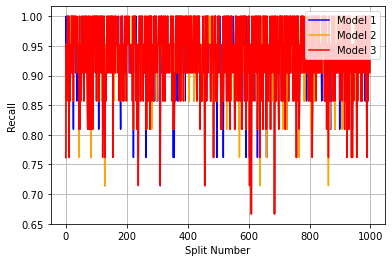

In [41]:
x= [i for i in range(0,1000)]
plt.plot(x, md1_results, color = 'blue')
plt.plot(x, md2_results, color = 'orange')
plt.plot(x, md3_results, color = 'red')
plt.xlabel('Split Number')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3'])
plt.grid()
plt.show();

In [36]:
#DONE
import xgboost as xgb 
#Define the input and target variable
x= project[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
y= project['fraud']

results= list()
results2= list()
results3= list()

#depth of 3 and LR .1

for i in range(0,1000):
    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify=y)
    
    
    #creating model
    xgb_md= xgb.XGBClassifier(max_depth= 3, n_estimators= 500, learning_rate= .1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred= xgb_md.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label= np.where(xgb_pred < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall= recall_score(y_test, xgb_label)
    results.append(xgb_recall)
    
    
    #creating model
    xgb_md2= xgb.XGBClassifier(max_depth= 3, n_estimators= 300, learning_rate= .1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred2= xgb_md2.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label2= np.where(xgb_pred2 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall2= recall_score(y_test, xgb_label2)
    results2.append(xgb_recall2)
    
    
    #creating model
    xgb_md3= xgb.XGBClassifier(max_depth= 3, n_estimators= 100, learning_rate= .1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred3= xgb_md3.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label3= np.where(xgb_pred3 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall3= recall_score(y_test, xgb_label3)
    results3.append(xgb_recall3)

In [37]:
#Computing averages
print('Average Recall for xgb model:', np.mean(results))
print('Average Recall for xgb model:', np.mean(results2))
print('Average Recall for xgb model:', np.mean(results3))

Average Recall for xgb model: 0.8594761904761906
Average Recall for xgb model: 0.8891428571428572
Average Recall for xgb model: 0.9441904761904764


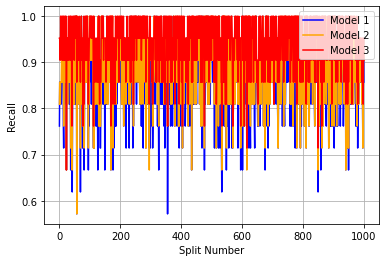

In [38]:
x= [i for i in range(0,1000)]
plt.plot(x, results, color = 'blue')
plt.plot(x, results2, color = 'orange')
plt.plot(x, results3, color = 'red')
plt.xlabel('Split Number')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3'])
plt.grid()
plt.show();

In [33]:
#DONE
import xgboost as xgb 
#Define the input and target variable
x= project[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
y= project['fraud']

results= list()
results2= list()
results3= list()

#depth of 5 and LR .1

for i in range(0,1000):
    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify=y)
    
    
    #creating model
    xgb_md= xgb.XGBClassifier(max_depth= 5, n_estimators= 500, learning_rate= .1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred= xgb_md.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label= np.where(xgb_pred < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall= recall_score(y_test, xgb_label)
    results.append(xgb_recall)
    
    
    #creating model
    xgb_md2= xgb.XGBClassifier(max_depth= 5, n_estimators= 300, learning_rate= .1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred2= xgb_md2.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label2= np.where(xgb_pred2 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall2= recall_score(y_test, xgb_label2)
    results2.append(xgb_recall2)
    
    
    #creating model
    xgb_md3= xgb.XGBClassifier(max_depth= 5, n_estimators= 100, learning_rate= .1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred3= xgb_md3.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label3= np.where(xgb_pred3 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall3= recall_score(y_test, xgb_label3)
    results3.append(xgb_recall3)

In [34]:
#Computing averages
print('Average Recall for xgb model:', np.mean(results))
print('Average Recall for xgb model:', np.mean(results2))
print('Average Recall for xgb model:', np.mean(results3))

Average Recall for xgb model: 0.8493333333333335
Average Recall for xgb model: 0.861
Average Recall for xgb model: 0.8950476190476193


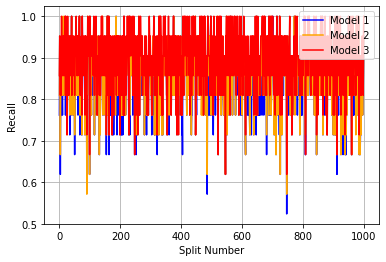

In [35]:
x= [i for i in range(0,1000)]
plt.plot(x, results, color = 'blue')
plt.plot(x, results2, color = 'orange')
plt.plot(x, results3, color = 'red')
plt.xlabel('Split Number')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3'])
plt.grid()
plt.show();

In [30]:
#DONE
import xgboost as xgb 
#Define the input and target variable
x= project[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
y= project['fraud']

results= list()
results2= list()
results3= list()

#depth of 7 and LR .1

for i in range(0,1000):
    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify=y)
    
    
    #creating model
    xgb_md= xgb.XGBClassifier(max_depth= 7, n_estimators= 500, learning_rate= .1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred= xgb_md.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label= np.where(xgb_pred < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall= recall_score(y_test, xgb_label)
    results.append(xgb_recall)
    
    
    #creating model
    xgb_md2= xgb.XGBClassifier(max_depth= 7, n_estimators= 300, learning_rate= .1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred2= xgb_md2.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label2= np.where(xgb_pred2 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall2= recall_score(y_test, xgb_label2)
    results2.append(xgb_recall2)
    
    
    #creating model
    xgb_md3= xgb.XGBClassifier(max_depth= 7, n_estimators= 100, learning_rate= .1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred3= xgb_md3.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label3= np.where(xgb_pred3 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall3= recall_score(y_test, xgb_label3)
    results3.append(xgb_recall3)

In [31]:
#Computing averages
print('Average Recall for xgb model:', np.mean(results))
print('Average Recall for xgb model:', np.mean(results2))
print('Average Recall for xgb model:', np.mean(results3))

Average Recall for xgb model: 0.8490000000000001
Average Recall for xgb model: 0.8550000000000001
Average Recall for xgb model: 0.8841904761904764


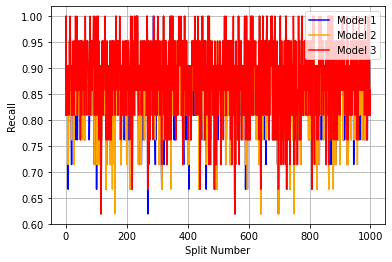

In [32]:
x= [i for i in range(0,1000)]
plt.plot(x, results, color = 'blue')
plt.plot(x, results2, color = 'orange')
plt.plot(x, results3, color = 'red')
plt.xlabel('Split Number')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3'])
plt.grid()
plt.show();

In [ ]:
#DONE
import xgboost as xgb 
#Define the input and target variable
x= project[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
y= project['fraud']

results= list()
results2= list()
results3= list()

#depth 3 and LR 1

for i in range(0,1000):
    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify=y)
    
    
    #creating model
    xgb_md= xgb.XGBClassifier(max_depth= 3, n_estimators= 500, learning_rate= 1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred= xgb_md.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label= np.where(xgb_pred < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall= recall_score(y_test, xgb_label)
    results.append(xgb_recall)
    
    
    #creating model
    xgb_md2= xgb.XGBClassifier(max_depth= 3, n_estimators= 300, learning_rate= 1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred2= xgb_md2.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label2= np.where(xgb_pred2 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall2= recall_score(y_test, xgb_label2)
    results2.append(xgb_recall2)
    
    
    #creating model
    xgb_md3= xgb.XGBClassifier(max_depth= 3, n_estimators= 100, learning_rate= 1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred3= xgb_md3.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label3= np.where(xgb_pred3 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall3= recall_score(y_test, xgb_label3)
    results3.append(xgb_recall3)

In [25]:
#Computing averages
print('Average Recall for xgb model:', np.mean(results))
print('Average Recall for xgb model:', np.mean(results2))
print('Average Recall for xgb model:', np.mean(results3))

Average Recall for xgb model: 0.8066666666666668
Average Recall for xgb model: 0.8122857142857144
Average Recall for xgb model: 0.826904761904762


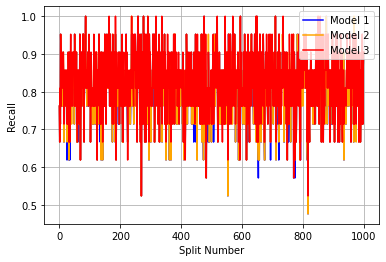

In [26]:
x= [i for i in range(0,1000)]
plt.plot(x, results, color = 'blue')
plt.plot(x, results2, color = 'orange')
plt.plot(x, results3, color = 'red')
plt.xlabel('Split Number')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3'])
plt.grid()
plt.show();

In [21]:
#DONE
import xgboost as xgb 
#Define the input and target variable
x= project[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
y= project['fraud']

results= list()
results2= list()
results3= list()

#depth 5 anf LR 1

for i in range(0,1000):
    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify=y)
    
    
    #creating model
    xgb_md= xgb.XGBClassifier(max_depth= 5, n_estimators= 500, learning_rate= 1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred= xgb_md.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label= np.where(xgb_pred < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall= recall_score(y_test, xgb_label)
    results.append(xgb_recall)
    
    
    #creating model
    xgb_md2= xgb.XGBClassifier(max_depth= 5, n_estimators= 300, learning_rate= 1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred2= xgb_md2.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label2= np.where(xgb_pred2 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall2= recall_score(y_test, xgb_label2)
    results2.append(xgb_recall2)
    
    
    #creating model
    xgb_md3= xgb.XGBClassifier(max_depth= 5, n_estimators= 100, learning_rate= 1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred3= xgb_md3.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label3= np.where(xgb_pred3 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall3= recall_score(y_test, xgb_label3)
    results3.append(xgb_recall3)

In [22]:
#Computing averages
print('Average Recall for xgb model:', np.mean(results))
print('Average Recall for xgb model:', np.mean(results2))
print('Average Recall for xgb model:', np.mean(results3))

Average Recall for xgb model: 0.8072380952380952
Average Recall for xgb model: 0.8121904761904762
Average Recall for xgb model: 0.8232857142857144


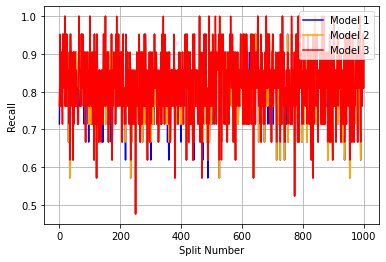

In [23]:
x= [i for i in range(0,1000)]
plt.plot(x, results, color = 'blue')
plt.plot(x, results2, color = 'orange')
plt.plot(x, results3, color = 'red')
plt.xlabel('Split Number')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3'])
plt.grid()
plt.show();

In [18]:
#DONE
import xgboost as xgb 
#Define the input and target variable
x= project[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
y= project['fraud']

results= list()
results2= list()
results3= list()

#depth 7 and LR 1

for i in range(0,1000):
    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify=y)
    
    
    #creating model
    xgb_md= xgb.XGBClassifier(max_depth= 7, n_estimators= 500, learning_rate= 1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred= xgb_md.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label= np.where(xgb_pred < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall= recall_score(y_test, xgb_label)
    results.append(xgb_recall)
    
    
    #creating model
    xgb_md2= xgb.XGBClassifier(max_depth= 7, n_estimators= 300, learning_rate= 1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred2= xgb_md2.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label2= np.where(xgb_pred2 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall2= recall_score(y_test, xgb_label2)
    results2.append(xgb_recall2)
    
    
    #creating model
    xgb_md3= xgb.XGBClassifier(max_depth= 7, n_estimators= 100, learning_rate= 1, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred3= xgb_md3.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label3= np.where(xgb_pred3 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall3= recall_score(y_test, xgb_label3)
    results3.append(xgb_recall3)

In [19]:
#Computing averages
print('Average Recall for xgb model:', np.mean(results))
print('Average Recall for xgb model:', np.mean(results2))
print('Average Recall for xgb model:', np.mean(results3))

Average Recall for xgb model: 0.8129047619047619
Average Recall for xgb model: 0.8170952380952382
Average Recall for xgb model: 0.8270476190476191


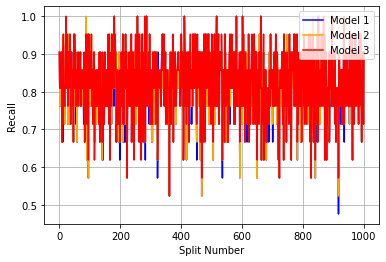

In [20]:
x= [i for i in range(0,1000)]
plt.plot(x, results, color = 'blue')
plt.plot(x, results2, color = 'orange')
plt.plot(x, results3, color = 'red')
plt.xlabel('Split Number')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3'])
plt.grid()
plt.show();

In [14]:
#DONE
import xgboost as xgb 
#Define the input and target variable
x= project[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
y= project['fraud']

results= list()
results2= list()
results3= list()

#depth 3 and LR .8

for i in range(0,1000):
    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify=y)
    
    
    #creating model
    xgb_md= xgb.XGBClassifier(max_depth= 3, n_estimators= 500, learning_rate= .8).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred= xgb_md.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label= np.where(xgb_pred < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall= recall_score(y_test, xgb_label)
    results.append(xgb_recall)
    
    
    #creating model
    xgb_md2= xgb.XGBClassifier(max_depth= 3, n_estimators= 300, learning_rate= .8).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred2= xgb_md2.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label2= np.where(xgb_pred2 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall2= recall_score(y_test, xgb_label2)
    results2.append(xgb_recall2)
    
    
    #creating model
    xgb_md3= xgb.XGBClassifier(max_depth= 3, n_estimators= 100, learning_rate= .8).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred3= xgb_md3.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label3= np.where(xgb_pred3 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall3= recall_score(y_test, xgb_label3)
    results3.append(xgb_recall3)

In [16]:
#Computing averages
print('Average Recall for xgb model:', np.mean(results))
print('Average Recall for xgb model:', np.mean(results2))
print('Average Recall for xgb model:', np.mean(results3))

Average Recall for xgb model: 0.8087142857142858
Average Recall for xgb model: 0.8135714285714287
Average Recall for xgb model: 0.831


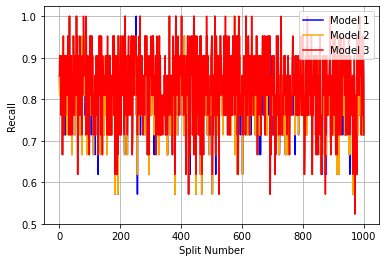

In [17]:
x= [i for i in range(0,1000)]
plt.plot(x, results, color = 'blue')
plt.plot(x, results2, color = 'orange')
plt.plot(x, results3, color = 'red')
plt.xlabel('Split Number')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3'])
plt.grid()
plt.show();

In [11]:
#DONE
import xgboost as xgb 
#Define the input and target variable
x= project[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
y= project['fraud']

results= list()
results2= list()
results3= list()

for i in range(0,1000):
    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify=y)
    
    
    #creating model
    xgb_md= xgb.XGBClassifier(max_depth= 5, n_estimators= 500, learning_rate= .8, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred= xgb_md.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label= np.where(xgb_pred < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall= recall_score(y_test, xgb_label)
    results.append(xgb_recall)
    
    
    #creating model
    xgb_md2= xgb.XGBClassifier(max_depth= 5, n_estimators= 300, learning_rate= .8, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred2= xgb_md2.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label2= np.where(xgb_pred2 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall2= recall_score(y_test, xgb_label2)
    results2.append(xgb_recall2)
    
    
    #creating model
    xgb_md3= xgb.XGBClassifier(max_depth= 5, n_estimators= 100, learning_rate= .8, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred3= xgb_md3.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label3= np.where(xgb_pred3 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall3= recall_score(y_test, xgb_label3)
    results3.append(xgb_recall3)

In [12]:
#Computing averages
print('Average Recall for xgb model:', np.mean(results))
print('Average Recall for xgb model:', np.mean(results2))
print('Average Recall for xgb model:', np.mean(results3))

Average Recall for xgb model: 0.8153333333333334
Average Recall for xgb model: 0.8202380952380953
Average Recall for xgb model: 0.8335714285714286


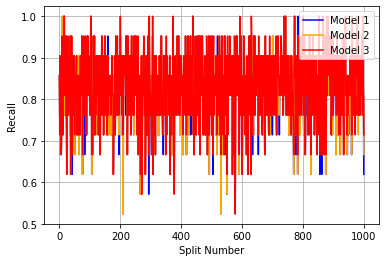

In [13]:
x= [i for i in range(0,1000)]
plt.plot(x, results, color = 'blue')
plt.plot(x, results2, color = 'orange')
plt.plot(x, results3, color = 'red')
plt.xlabel('Split Number')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3'])
plt.grid()
plt.show();

In [ ]:
#DONE
import xgboost as xgb 
#Define the input and target variable
x= project[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
y= project['fraud']

results= list()
results2= list()
results3= list()

#depth 7 and LR 1

for i in range(0,1000):
    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify=y)
    
    
    #creating model
    xgb_md= xgb.XGBClassifier(max_depth= 7, n_estimators= 500, learning_rate= .8, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred= xgb_md.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label= np.where(xgb_pred < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall= recall_score(y_test, xgb_label)
    results.append(xgb_recall)
    
    
    #creating model
    xgb_md2= xgb.XGBClassifier(max_depth= 7, n_estimators= 300, learning_rate= .8, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred2= xgb_md2.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label2= np.where(xgb_pred2 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall2= recall_score(y_test, xgb_label2)
    results2.append(xgb_recall2)
    
    
    #creating model
    xgb_md3= xgb.XGBClassifier(max_depth= 7, n_estimators= 100, learning_rate= .8, ).fit(x_train, y_train)
    #predicitng on the model
    xgb_pred3= xgb_md3.predict_proba(x_test)[:,1]
    #Changling likleyhoods to labels
    xgb_label3= np.where(xgb_pred3 < .1, 0, 1)
    #Computing recall and appending score
    xgb_recall3= recall_score(y_test, xgb_label3)
    results3.append(xgb_recall3)

In [8]:
#Computing averages
print('Average Recall for xgb model:', np.mean(results))
print('Average Recall for xgb model:', np.mean(results2))
print('Average Recall for xgb model:', np.mean(results3))

Average Recall for xgb model: 0.817047619047619
Average Recall for xgb model: 0.8213333333333335
Average Recall for xgb model: 0.8327142857142857


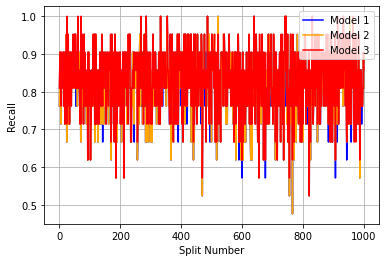

In [10]:
x= [i for i in range(0,1000)]
plt.plot(x, results, color = 'blue')
plt.plot(x, results2, color = 'orange')
plt.plot(x, results3, color = 'red')
plt.xlabel('Split Number')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3'])
plt.grid()
plt.show();